<html><head>


<!-- Load require.js. Delete this if your page already loads require.js -->
<script src="https://cdnjs.cloudflare.com/ajax/libs/require.js/2.3.4/require.min.js" integrity="sha256-Ae2Vz/4ePdIu6ZyI/5ZGsYnb+m0JlOmKPjt6XZ9JJkA=" crossorigin="anonymous"></script>
<script src="https://unpkg.com/@jupyter-widgets/html-manager@*/dist/embed-amd.js" crossorigin="anonymous"></script>
<script type="application/vnd.jupyter.widget-state+json">
{
    "version_major": 2,
    "version_minor": 0,
    "state": {}
}
</script>
</head>
<body>


</body>
</html>



# Differential expression analyses using Sleuth

<html>
    <script>
    // AUTORUN ALL CELLS ON NOTEBOOK-LOAD!
    require(
        ['base/js/namespace', 'jquery'], 
        function(jupyter, $) {
            $(jupyter.events).on("kernel_ready.Kernel", function () {
                console.log("Auto-running all cells-below...");
                jupyter.actions.call('jupyter-notebook:run-all-cells-below');
                jupyter.actions.call('jupyter-notebook:save-notebook');
            });
        }
    );
   </script   
</html>


Sleuth performs differential expression analyses by aggregating related samples. Sleuth is a R application written by the Pachter Lab.

### Install sleuth and biomaRt
#### Note that installing these R and bioconductor packages takes ~5-10 minutes

In [1]:
library('sleuth')

### Create sample table

The text file called "sample_info.tsv" provides information whether each sample is the control or corresponds to KOXA1 knockdown.  In addition, the path of the transcript abundance file for each sample is specified.

In [2]:
s2c <- read.table("/data/sleuth/exp_desc.tsv", header = TRUE, stringsAsFactors = FALSE)
t2g <- read.table("/data/t2g.tsv",sep='\t')

### Fitting the sleuth model

Now the “sleuth object” can be constructed. This requires three commands that 
1. load the kallisto processed data into the object 
2. estimate parameters for the sleuth response error measurement model and 
3. perform differential analyis (testing). 

In [3]:
so <- sleuth_prep(s2c, extra_bootstrap_summary = TRUE, num_cores = 2)

reading in kallisto results
dropping unused factor levels
......
normalizing est_counts
169 targets passed the filter
normalizing tpm
merging in metadata
summarizing bootstraps



If the sleuth commands return an error, this is likely due to an incorrect abundance file generated by kallisto. Re-run the kallisto step.  Note that this is not an issue with nbdocker but a known issue with kallisto (for an example see https://github.com/pachterlab/sleuth/issues/120 )

In [4]:
#so <- sleuth_prep(s2c, target_mapping = t2g)
so <- sleuth_fit(so, ~condition, 'full')
so <- sleuth_fit(so, ~1, 'reduced')
so <- sleuth_lrt(so, 'reduced', 'full')
models(so)

fitting measurement error models
shrinkage estimation
2 NA values were found during variance shrinkage estimation due to mean observation values outside of the range used for the LOESS fit.
The LOESS fit will be repeated using exact computation of the fitted surface to extrapolate the missing values.
These are the target ids with NA values: ENST00000394934.4, ENST00000435761.5
computing variance of betas
fitting measurement error models
shrinkage estimation
computing variance of betas


[  full  ]
formula:  ~condition 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)
 	conditionscramble
[  reduced  ]
formula:  ~1 
data modeled:  obs_counts 
transform sync'ed:  TRUE 
coefficients:
	(Intercept)


In [5]:
sleuth_table <- sleuth_results(so, 'reduced:full', 'lrt', show_all = FALSE)
sleuth_significant <- dplyr::filter(sleuth_table, qval <= 0.05)
head(sleuth_significant, 20)

target_id,pval,qval,test_stat,rss,degrees_free,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq
ENST00000233813.4,6.751457e-06,0.001140996,20.262397,1.0791196,1,4.6829204,0.2158239,0.010918333,0.20490559,1.079732e-03,0.20490559
ENST00000223095.4,1.812291e-04,0.015313858,14.016338,3.5761368,1,2.9091846,0.7152274,0.072945567,0.64228180,1.512779e-04,0.64228180
ENST00000225964.9,4.446379e-04,0.019468864,12.334606,0.1061515,1,5.3027048,0.0212303,0.005903332,0.01532697,6.319518e-03,0.01532697
ENST00000372764.3,4.959896e-04,0.019468864,12.130683,3.3487915,1,2.7208849,0.6697583,0.085654965,0.58410334,8.436316e-05,0.58410334
ENST00000435761.5,5.760019e-04,0.019468864,11.851976,10.6220692,1,0.6369383,2.1244138,0.442361735,1.68205210,2.265114e+00,2.26511381
ENST00000325888.12,9.146985e-04,0.022083435,10.992733,19.3245043,1,1.1015807,3.8649009,1.343295292,2.52160558,4.338803e-01,2.52160558
ENST00000327773.6,8.080125e-04,0.022083435,11.222737,10.8894309,1,0.6423888,2.1778862,0.513268631,1.66461755,2.234230e+00,2.23422983
ENST00000224237.9,1.151252e-03,0.024320189,10.566988,0.5489743,1,3.4682604,0.1097949,0.034576761,0.07521810,1.716601e-04,0.07521810
ENST00000319211.4,1.405550e-03,0.026393104,10.198499,3.3595826,1,1.8203328,0.6719165,0.234901913,0.43701460,4.536862e-05,0.43701460
ENST00000290271.6,1.781729e-03,0.030111225,9.761825,15.9831462,1,1.4730127,3.1966292,0.127078255,3.06955099,2.109257e-02,3.06955099


The table shown above displays the top 20 significant genes with a (Benjamini-Hochberg multiple testing corrected) q-value <= 0.05.

The next cell does a box plot of the expression for the 3 samples of the most differentially expressed gene in the treatment and control experiments.

[1] "ENST00000233813.4"

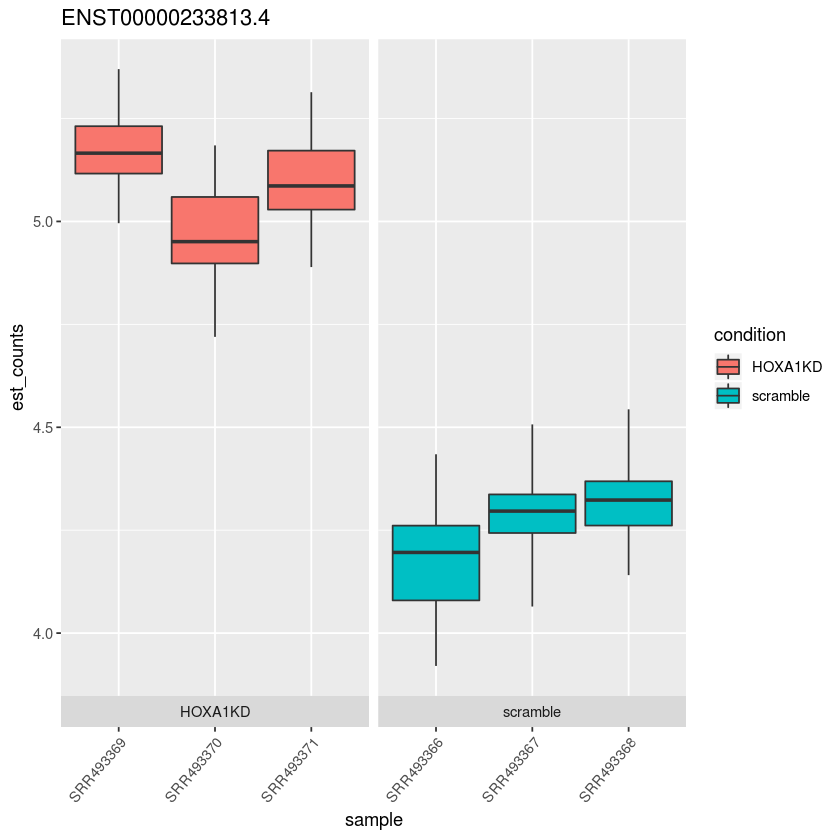

In [6]:
topid <- sleuth_significant[1,1]
topid

plot_bootstrap(so, topid, units = "est_counts", color_by = "condition")